In [92]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [93]:
def load_image(url): 
    image = Image.open(url)
    image = np.array(image)
    image = image / 255
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float()
    return image

In [94]:
train_x = [load_image(f'Resized_Dataset\\train\\{i}') for i in os.listdir("Resized_Dataset\\train")]
train_y = [0 if (i.split('_')[1])=="healthy.jpg" else 1 for i in os.listdir("Resized_Dataset\\train")]
test_x = [load_image(f'Resized_Dataset\\test\\{i}') for i in os.listdir("Resized_Dataset\\test")]
test_y = [0 if (i.split('_')[1])=="healthy.jpg" else 1 for i in os.listdir("Resized_Dataset\\test")]
print(len(train_x), len(train_y), len(test_x), len(test_y))
#train_x = [load_image(f') for i in range(1, 50001)]

160 160 40 40


In [95]:
train_x = torch.stack(train_x)
train_y = torch.tensor(train_y)

test_x = torch.stack(test_x)
test_y = torch.tensor(test_y)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([160, 3, 224, 224]) torch.Size([160]) torch.Size([40, 3, 224, 224]) torch.Size([40])


In [96]:
# Making Dataloader
batch_size = 16
train_data = torch.utils.data.TensorDataset(train_x, train_y)
test_data = torch.utils.data.TensorDataset(test_x, test_y)
# Setting random seed in train_loader for shuffling

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [97]:
class VGG1(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(10*112*112, 30),
            nn.ReLU(),
            nn.Linear(30, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    
class VGG2(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(10, 20, kernel_size=3, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(20*56*56, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out


In [116]:
model = VGG2().to(device)
# Loss and optimizer
# Binary Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [117]:
print(len(train_loader))

10


In [118]:
for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    print(images.shape)
    print(labels)
    break

torch.Size([16, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')


In [125]:
# Train the model
total_step = len(train_loader)
num_epochs = 30
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/30], Step [1/10], Loss: 0.0029
Epoch [1/30], Step [2/10], Loss: 0.0029
Epoch [1/30], Step [3/10], Loss: 0.0018
Epoch [1/30], Step [4/10], Loss: 0.0010
Epoch [1/30], Step [5/10], Loss: 0.0035
Epoch [1/30], Step [6/10], Loss: 0.0018
Epoch [1/30], Step [7/10], Loss: 0.0047
Epoch [1/30], Step [8/10], Loss: 0.0023
Epoch [1/30], Step [9/10], Loss: 0.0016
Epoch [1/30], Step [10/10], Loss: 0.0008
Epoch [2/30], Step [1/10], Loss: 0.0013
Epoch [2/30], Step [2/10], Loss: 0.0023
Epoch [2/30], Step [3/10], Loss: 0.0028
Epoch [2/30], Step [4/10], Loss: 0.0013
Epoch [2/30], Step [5/10], Loss: 0.0025
Epoch [2/30], Step [6/10], Loss: 0.0025
Epoch [2/30], Step [7/10], Loss: 0.0018
Epoch [2/30], Step [8/10], Loss: 0.0021
Epoch [2/30], Step [9/10], Loss: 0.0042
Epoch [2/30], Step [10/10], Loss: 0.0011
Epoch [3/30], Step [1/10], Loss: 0.0009
Epoch [3/30], Step [2/10], Loss: 0.0016
Epoch [3/30], Step [3/10], Loss: 0.0052
Epoch [3/30], Step [4/10], Loss: 0.0017
Epoch [3/30], Step [5/10], Loss: 0.002

In [126]:
# Calculate Accuracy
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 40 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 40 test images: 85.0 %


Predicted: 0, Actual: 1
107_diseased.jpg


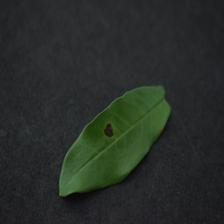


Predicted: 0, Actual: 1
178_diseased.jpg


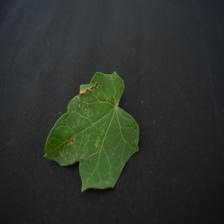


Predicted: 1, Actual: 0
186_healthy.jpg


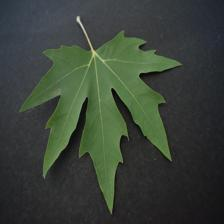


Predicted: 0, Actual: 1
1_diseased.jpg


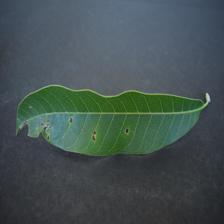


Predicted: 1, Actual: 0
85_healthy.jpg


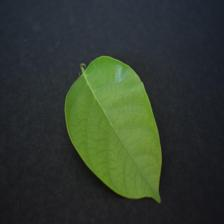


Predicted: 1, Actual: 0
91_healthy.jpg


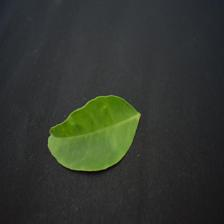

In [127]:
# Let us view the miscassified images
test_paths = os.listdir("Resized_Dataset\\test")
model.eval()
for path in test_paths:
    image = load_image(f'Resized_Dataset\\test\\{path}').unsqueeze(0).to(device)
    label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    if predicted != label:
        print(f"Predicted: {predicted.item()}, Actual: {label}")
        print(path)
        display(Image.open(f'Resized_Dataset\\test\\{path}'))
        print("")

